## SIR
Here we simulate the evolution of a pandemic with the SIR model. <br>
Various actions are possible to the system, which learns the better policy through a reinforcement learning tecnique called NEAT.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GSIR():
    
    def __init__(self, R0=2, gamma=0.5, N=60e+6, I=1, report=False):
        self.N = N               # Total number of people
        self.I0 = I              # Initial infective
        self.I = I               # Infective
        self.R = 0               # Recovered
        self.S = self.N - self.I # Susceptible
        self.int_ter = 152e+3    # Places in intensive terapy in hospitals
        
        self.beta0 = R0*gamma     # Initial infection rate
        self.gamma0 = gamma       # Initial recovering rate
        self.beta = R0*gamma      # Infection rate
        self.gamma = gamma        # Recovering rate
        self.chi = 0.05           # Knowing rate. The "system" knows only the worst
                                  # cases, 5%. Can be augmented with tests.
        self.old_chi = 0.05
        
        self.res_founds = 10       # Invest in research
        self.t_borders = 0        # Days from start of closure of borders
        self.t_quarantine = 0     # Days from start quarantine
        self.rew = 0              # Reward of the process
        self.num_ac = 11          # Number of possible actions from the system
        self.ac_report = np.zeros( self.num_ac )
        
        self.k = self.I*self.chi/self.N  # Known infected.
        self.O = [self.k, self.res_founds] # Observations known to the network
        self.report = report      # If true write on file the actions
        self.status = 'Running'   # Status of the system
        if self.report:
            self.writer = open('reporter.txt', 'w')
            self.evolution = [[self.beta], [gamma], [self.chi] ]
            self.Ss = []
            self.Is = []
            self.Rs = []
        
    def reset(self):
        self.__init__(N=self.N, I=self.I0, R0=self.beta0/self.gamma0, gamma=self.gamma0,
                     report=self.report)
                
    def SIR(self):
        dS = -self.beta*self.S*self.I/self.N
        dI = self.beta*self.S*self.I/self.N - self.gamma*self.I
        dR = self.gamma*self.I
        
        self.S += dS
        self.I += dI
        self.R += dR
        
    def action_sel(self, ac):
        index = ac.argmax()
        return index
    
    def ac0(self):
        """ Do nothing """
        self.ac_report[0] += 1
        
    def ac1(self):
        """ Use minor protection, like mask and washing hands. No "rage" from people. """
        if self.ac_report[1] == 0:
            self.beta *= 0.9              # Arbitrary, to be determine from data
        self.ac_report[1] += 1
        
    def ac2(self):
        """ Close country frontiers. Small rage from people. """
        if self.ac_report[2] == 0:
            self.beta *= 0.8
            self.ac_report[2] += 1
        
    def ac3(self):
        """ Remove block on frontiers. """
        if self.ac_report[2] == 1:
            self.beta /= 0.8
            self.ac_report[2] -= 1
            self.t_borders = 0
        self.ac_report[3] += 1
            
    def ac4(self):
        """ Quarantine. Medium rage from people. """
        if self.ac_report[4] == 0:
            self.beta *= 0.5
            self.ac_report[4] += 1
            
    def ac5(self):
        """ Remove quarantine. """
        if self.ac_report[4] == 1:
            self.beta /= 0.5
            self.ac_report[4] -= 1       
            self.t_quarantine = 0
        self.ac_report[5] += 1
        
    def ac6(self):
        """ Selective quarantine. """
        if self.ac_report[6] == 0:
            self.beta *= (1-self.chi)
            self.old_chi = self.chi
            self.ac_report[6] += 1
            
    def ac7(self):
        """ Remove selective quarantine. """
        if self.ac_report[6] == 1:
            self.ac_report[6] -= 1
            self.beta /= (1-self.old_chi)
        self.ac_report[7] += 1
        
    def ac8(self):
        """ Invest in research. """
        self.res_founds += 1
        self.ac_report[8] += 1
        
    def ac9(self):
        """ Spend founds in tests. """
        if self.res_founds >= 5:
            self.res_founds -= 5
            self.chi /= 0.9       # Increase number of people visible from the system
        self.ac_report[9] += 1
        
    def ac10(self):
        """ Spend founds in better cure. """
        if self.res_founds >= 5:
            self.res_founds -= 5
            self.gamma /= 0.9    # Increase number of recovered people
        self.ac_report[10] += 1
        
#    def ac11(self):
#        """ For greater good. """
#        self.I -= chi*self.I    # Kill all the known infects
#        self.rew -= 5
        
    def _reward(self):
        if self.S >= 1:
            if self.ac_report[2] > 0: # Rage from closing the country
                self.rew -= (1 - np.exp(-0.005*self.t_borders) )
                self.t_borders += 1
            if self.ac_report[4] > 0: # Rage from quarantine
                self.rew -= (1 - np.exp(-0.01*self.t_quarantine) )
                self.t_quarantine += 1
            if self.I*0.05 >= self.int_ter:
                self.rew -= 10
            self.rew += 1 - self.I/self.N
            
    def _update(self, index):
        if   index == 0:  self.ac0()
        elif index == 1:  self.ac1() 
        elif index == 2:  self.ac2() 
        elif index == 3:  self.ac3() 
        elif index == 4:  self.ac4() 
        elif index == 5:  self.ac5() 
        elif index == 6:  self.ac6() 
        elif index == 7:  self.ac7() 
        elif index == 8:  self.ac8() 
        elif index == 9:  self.ac9() 
        elif index == 10: self.ac10() 
        elif index == 11: self.ac11() 
        
    def _upd_obs(self):
        self.k = (self.S*self.chi)/self.N  # Known infected-intensive ter beds.
        self.O = [self.k, self.res_founds] # Observations known to the network
    
    def _report(self, index, num):
        self.ac_des = ['00) Do nothing. \n', 
                       '01) Use minor protection, like mask and washing hands. \n',
                       '02) Close country borders. \n',
                       '03) Remove block on borders. \n',
                       '04) Imposing quarantine. \n',
                       '05) Remove quarantine. \n',
                       '06) Impose quarantine only on known infected. \n',
                       '07) Remove selective quarantine. \n',
                       '08) Invest in research. \n',
                       '09) Spend research founds in test. \n',
                       '10) Spend research founds in searching for a cure. \n',
                       '11) Kill all known infects. \n'
                      ]
        if num%3==0:
            self.writer.write(self.ac_des[index])
        self.evolution[0].append( self.beta )
        self.evolution[1].append( self.gamma )
        self.evolution[2].append( self.chi )
        self.Ss.append( self.S/env.N )
        self.Is.append( self.I/env.N )
        self.Rs.append( self.R/env.N )
        
    def close_rep(self):
        if self.report:
            self.writer.close()
    
    def step(self, actions):
        index = self.action_sel(actions)
        self._update(index)
        for _ in range(3):
            self.SIR()
            self._reward()
            self._upd_obs()
            if self.report: self._report(index, 3)
            
        if self.I < 1: self.status = 'Finished'
            

In [3]:
env = GSIR(R0=3, report=True)

np.random.seed(123)
env.reset()
ac = np.zeros(11)
ac[0]=1
for i in range(20):
    env.step(ac)
S0 = env.Ss
I0 = env.Is
R0 = env.Rs

env.reset()
ac = np.random.uniform(0,1, 11)
for i in range(20):
    env.step(ac)
S = env.Ss
I = env.Is
R = env.Rs

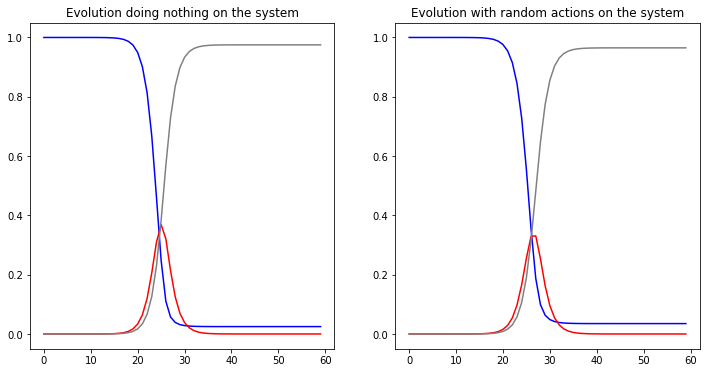

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Evolution doing nothing on the system')
ax[0].plot(S0, color='blue')
ax[0].plot(I0, color='red')
ax[0].plot(R0, color='gray')

ax[1].set_title('Evolution with random actions on the system')
ax[1].plot(S, color='blue')
ax[1].plot(I, color='red')
ax[1].plot(R, color='gray')
plt.show()

Here starts the NEAT algorithm

In [3]:
from SaveLoadNet import load_object, save_object
from visualize import draw_net
import neat
import os

config_file = os.path.join('.', './../Config/config_gestional.txt')
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

In [6]:
env = GSIR(I=10000, R0=2.5)

def eval_genomes(genomes, config):
    networks = [neat.nn.RecurrentNetwork.create(genome, config) for (genomeid, genome) in genomes]    
    obs = env.O
    rew = []
    T = 500
    dt = 3
    
    for net in networks:
        temp_rew = []
        env.reset()
        for _ in range(20):
            for i in range(T):
                actions = np.array( net.activate(obs) )
                env.step(actions)
                obs = env.O
                if env.status == 'Finished': break
                #if env.S > env.int_ter: break
            temp_rew.append( env.rew )
            env.reset()
            
        temp_rew = np.array(temp_rew)
        rew.append( temp_rew.mean()/(dt) )

    for i, (genomeid, genome) in enumerate(genomes):
            genome.fitness = rew[i]


    env.reset()

In [7]:
p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
#p.add_reporter(neat.Checkpointer(5))
N_iter = 100
singol = p.run(eval_genomes, N_iter)


 ****** Running generation 0 ****** 

Population's average fitness: -13.42940 stdev: 12.86084
Best fitness: 30.83944 - size: (12, 24) - species 1 - id 168
Average adjusted fitness: 0.159
Mean genetic distance 2.364, standard deviation 0.241
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   250    -13.4    0.159     0
Total extinctions: 0
Generation time: 6.478 sec

 ****** Running generation 1 ****** 

Population's average fitness: -5.47240 stdev: 21.37256
Best fitness: 31.45145 - size: (12, 19) - species 1 - id 433
Average adjusted fitness: 0.779
Mean genetic distance 2.474, standard deviation 0.268
Population of 250 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   132     -5.5    0.779     0
     2    0   102       --       --     0
     3    0    16       --       --     0
Total extinctions: 0
Generation time: 7.359 sec (6.91

Population's average fitness: 7.82546 stdev: 23.74663
Best fitness: 33.46029 - size: (11, 3) - species 2 - id 3756
Average adjusted fitness: 0.620
Mean genetic distance 2.406, standard deviation 0.338
Population of 250 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   15    40      3.9    0.551     5
     2   14   145     10.4    0.649     6
     3   14    65     11.1    0.661    11
Total extinctions: 0
Generation time: 17.649 sec (15.104 average)

 ****** Running generation 16 ****** 

Population's average fitness: 7.82418 stdev: 23.50388
Best fitness: 33.46029 - size: (13, 7) - species 2 - id 4009
Average adjusted fitness: 0.525
Mean genetic distance 2.392, standard deviation 0.369
Population of 250 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   16    47      5.4    0.492     6
     2   15    58      8.5    0.547     7
     3   15   143      7.9    0.53

Population's average fitness: 8.97639 stdev: 25.56223
Best fitness: 34.09517 - size: (11, 2) - species 4 - id 7685
Average adjusted fitness: 0.857
Mean genetic distance 2.177, standard deviation 0.341
Population of 250 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   30    78      8.0    0.852    11
     4   14   172      9.6    0.861     8
Total extinctions: 0
Generation time: 19.777 sec (18.533 average)

 ****** Running generation 31 ****** 

Population's average fitness: 10.77182 stdev: 24.00125
Best fitness: 36.34291 - size: (12, 6) - species 4 - id 7920
Average adjusted fitness: 0.610
Mean genetic distance 2.253, standard deviation 0.339
Population of 250 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   31   105      6.3    0.563    12
     4   15   145     12.8    0.658     9
Total extinctions: 0
Generation time: 22.871 sec (19.245 average)

 ****** 

Population's average fitness: 10.04178 stdev: 24.70974
Best fitness: 33.46029 - size: (13, 3) - species 5 - id 11259
Average adjusted fitness: 0.637
Mean genetic distance 2.395, standard deviation 0.468
Population of 250 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   13    49      2.6    0.531     6
     6   10   119     11.2    0.662     9
     7    4    82     14.9    0.718     1
Total extinctions: 0
Generation time: 21.008 sec (18.522 average)

 ****** Running generation 46 ****** 

Population's average fitness: 6.28088 stdev: 24.34997
Best fitness: 33.46029 - size: (13, 4) - species 5 - id 11507
Average adjusted fitness: 0.573
Mean genetic distance 2.541, standard deviation 0.499
Population of 249 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   14    52      1.7    0.518     7
     6   11   112      8.3    0.618    10
     7    5    74      6.0    0

Population's average fitness: 8.89430 stdev: 25.02488
Best fitness: 33.46029 - size: (11, 2) - species 5 - id 14748
Average adjusted fitness: 0.629
Mean genetic distance 2.345, standard deviation 0.445
Population of 249 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   27    20      2.2    0.525    10
     6   24    66      8.3    0.617     7
     7   18   102     11.3    0.663     3
     8   13    30     12.6    0.683     3
     9    6    31     10.9    0.657     5
Total extinctions: 0
Generation time: 18.808 sec (18.204 average)

 ****** Running generation 60 ****** 

Population's average fitness: 5.84993 stdev: 24.78065
Best fitness: 33.46029 - size: (16, 4) - species 7 - id 15000
Average adjusted fitness: 0.585
Mean genetic distance 2.460, standard deviation 0.479
Population of 249 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   28   128      7.4    0.

Population's average fitness: 11.20185 stdev: 24.24795
Best fitness: 33.46029 - size: (17, 9) - species 9 - id 18002

Species 6 with 18 members is stagnated: removing it
Average adjusted fitness: 0.672
Mean genetic distance 2.652, standard deviation 0.564
Population of 250 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   40    40     12.2    0.678     5
     7   31    55     15.7    0.730     3
     8   26    94     11.4    0.665     4
     9   19    34      8.8    0.625    18
    10    9    27     11.3    0.664     3
Total extinctions: 0
Generation time: 21.488 sec (19.413 average)

 ****** Running generation 73 ****** 

Population's average fitness: 11.59759 stdev: 24.10396
Best fitness: 33.46029 - size: (15, 4) - species 8 - id 18252
Average adjusted fitness: 0.683
Mean genetic distance 2.748, standard deviation 0.563
Population of 250 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  

Population's average fitness: 14.35231 stdev: 22.90172
Best fitness: 33.46029 - size: (15, 5) - species 10 - id 21006
Average adjusted fitness: 0.684
Mean genetic distance 2.740, standard deviation 0.482
Population of 251 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   52    49     19.1    0.740     1
     7   43    31     22.0    0.793     0
     8   38    27     14.6    0.659     6
    10   21    23     13.2    0.633    11
    11   11    34     13.3    0.634     7
    12    9    56     12.9    0.628     3
    13    9    31     16.9    0.701     6
Total extinctions: 0
Generation time: 21.820 sec (21.186 average)

 ****** Running generation 85 ****** 

Population's average fitness: 14.18758 stdev: 22.97377
Best fitness: 33.49374 - size: (20, 10) - species 12 - id 21253
Average adjusted fitness: 0.649
Mean genetic distance 2.764, standard deviation 0.425
Population of 251 members in 7 species:
   ID   age  size  fitness 

Population's average fitness: 12.99737 stdev: 23.30044
Best fitness: 33.46029 - size: (17, 7) - species 11 - id 24007
Average adjusted fitness: 0.608
Mean genetic distance 2.740, standard deviation 0.511
Population of 251 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   64     9      5.0    0.436     1
     7   55    37     19.4    0.720     3
     8   50    41     10.4    0.543     5
    10   33    11     11.5    0.565    10
    11   23    88     18.6    0.705     3
    12   21    16     14.4    0.622     6
    13   21    25     17.2    0.678    18
    14    3    24     12.9    0.592     2
Total extinctions: 0
Generation time: 22.095 sec (25.004 average)

 ****** Running generation 97 ****** 

Population's average fitness: 15.15958 stdev: 23.11450
Best fitness: 33.46029 - size: (18, 5) - species 5 - id 24257
Average adjusted fitness: 0.658
Mean genetic distance 2.774, standard deviation 0.483
Population of 251 members i

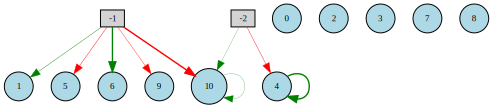

In [8]:
draw_net(config, singol)

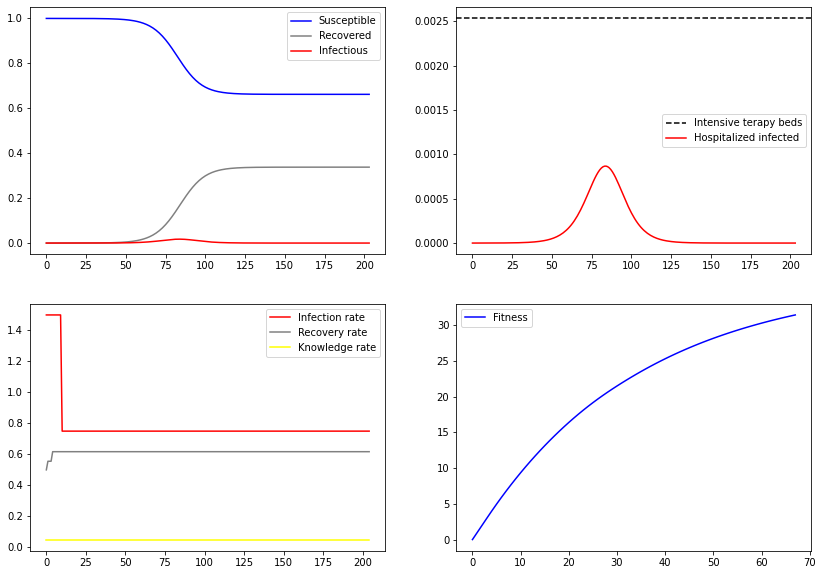

In [10]:
best_net = neat.nn.RecurrentNetwork.create(singol, config)
env = GSIR(report=True, R0=3)
obs = env.O
rew = []

T=200
dt=3

for i in range(T):
    rew.append( env.rew )
    actions = np.array( best_net.activate(obs) )
    env.step(actions)
    obs = env.O
    if env.status == 'Finished': break

S = np.array(env.Ss)
R = np.array(env.Rs)
I = np.array(env.Is)
ter = env.int_ter/env.N
        
fig, ax = plt.subplots(2, 2, figsize=(14,10) )
ax = ax.flatten()
ax[0].plot(S, color='blue', label= 'Susceptible')
ax[0].plot(R, color='gray', label= 'Recovered')
ax[0].plot(I, color='red', label= 'Infectious')
ax[0].legend()

ax[1].axhline(ter, ls='--', color='black', label= 'Intensive terapy beds')
ax[1].plot(I*0.05, color='red', label='Hospitalized infected')
ax[1].legend()

ax[2].plot( env.evolution[0], color='red', label='Infection rate')
ax[2].plot( env.evolution[1], color='gray', label='Recovery rate')
ax[2].plot( env.evolution[2], color='yellow', label='Knowledge rate')
#ax[2].plot(np.array(env.evolution[0])/np.array( env.evolution[1]), color='green', label='R0')
ax[2].legend()
#ax[2].set_xlim(0, 15)

ax[3].plot(np.array(rew)/(dt), color='blue', label='Fitness')
ax[3].legend()

plt.show()

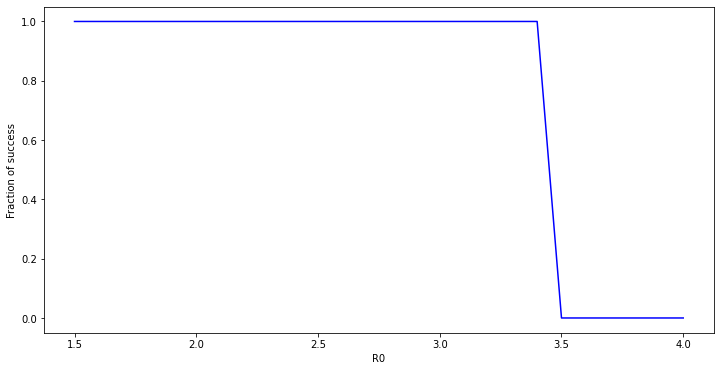

In [11]:
R0s = np.arange(1.5, 4.1, 0.1)
N = 100
success = np.zeros(len(R0s))
for i, r in enumerate(R0s):
    env = GSIR(report=True, R0=r)
    T=200
    dt=3
    for k in range(N):
        env.reset()
        obs = env.O
        for _ in range(T):
            actions = np.array( best_net.activate(obs) )
            env.step(actions)
            obs = env.O
            if env.status == 'Finished': break
        if max(env.Is)*0.05 < env.int_ter/env.N :
            success[i] += 1
success /= N

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(R0s, success, color='blue')
ax.set_xlabel('R0')
ax.set_ylabel('Fraction of success')
plt.savefig('SIR_success.png')

In [12]:
#save_object(singol, 'SIR_argmax')

### Code to plot in LateX-friendly format

In [4]:
singol = load_object('SIR_argmax') 

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# Plotting LateX figures
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.facecolor'] = 'white'

In [13]:
env = GSIR(R0=3, report=True)

np.random.seed(123)
env.reset()
ac = np.zeros(11)
ac[0]=1
for i in range(20):
    env.step(ac)
S0 = env.Ss
I0 = env.Is
R0 = env.Rs


In [6]:
fig, ax = plt.subplots( figsize=(3.5, 2.5))
ax.set_title('SIR model')
ax.plot(S0, color='blue', label='Susceptible')
ax.plot(I0, color='red', label='Infected')
ax.plot(R0, color='gray', label='Recovered')
ax.set_xlabel('Time [days]')
ax.set_ylabel('Populations')
ax.legend()
ax.set_facecolor((1.0, 1.0, 1.0))

plt.tight_layout()
plt.savefig('SIR.pgf', facecolor=(1,1,1,0))

NameError: name 'S0' is not defined

In [15]:
#singol = load_object('rew_hacking')
#best_net = neat.nn.RecurrentNetwork.create(singol, config)

In [7]:
best_net = neat.nn.RecurrentNetwork.create(singol, config)
env = GSIR(report=True, R0=3)
obs = env.O
rew = []

T=200
dt=3

for i in range(T):
    rew.append( env.rew )
    actions = np.array( best_net.activate(obs) )
    env.step(actions)
    obs = env.O
    if env.status == 'Finished': break

S = np.array(env.Ss)
R = np.array(env.Rs)
I = np.array(env.Is)
ter = env.int_ter/env.N
        
fig, ax = plt.subplots(2, 2, figsize=(4.3,3) )
ax = ax.flatten()
ax[0].plot(S, color='blue', label= 'S')
ax[0].plot(R, color='gray', label= 'R')
ax[0].plot(I, color='red', label= 'I')
ax[0].legend()
ax[0].set_ylabel('Population')

ax[1].axhline(ter, ls='--', color='black', label= 'Max beds')
ax[1].plot(I*0.05, color='red', label= 'Serious I')
ax[1].legend()

ax[2].plot( env.evolution[0], color='red', label='b')
ax[2].plot( env.evolution[1], color='gray', label='g')
ax[2].plot( env.evolution[2], color='yellow', label='c')
#ax[2].plot(np.array(env.evolution[0])/np.array( env.evolution[1]), color='green', label='R0')
ax[2].legend(loc=4)
ax[2].set_ylabel('Rate')
ax[2].set_xlabel('Time [days]')
#ax[2].set_xlim(0, 15)

ax[3].plot(np.array(rew)/(dt), color='blue', label='Fitness')
ax[3].set_ylabel('Fitness')
ax[3].set_xlabel('Time [days]')
ax[3].legend()

if max(I*0.05) > env.int_ter/env.N: print('Not good')
plt.tight_layout()
plt.savefig('evol_good.pgf', facecolor=(1,1,1,0))
plt.close()

In [8]:
R0s = np.arange(1.5, 4.1, 0.1)
N = 100
success = np.zeros(len(R0s))
for i, r in enumerate(R0s):
    env = GSIR(report=True, R0=r)
    T=200
    dt=3
    for k in range(N):
        env.reset()
        obs = env.O
        for _ in range(T):
            actions = np.array( best_net.activate(obs) )
            env.step(actions)
            obs = env.O
            if env.status == 'Finished': break
        if max(env.Is)*0.05 < env.int_ter/env.N :
            success[i] += 1
success /= N


In [9]:
fig, ax = plt.subplots(figsize=(4.3, 2))
ax.plot(R0s, success, color='blue')
ax.set_xlabel('Ra')
ax.set_ylabel('Fraction of success')
plt.tight_layout()
plt.savefig('SIR_success.pgf', facecolor=(1,1,1,0))